In [157]:
%load_ext autoreload
%autoreload 2

import json
from pathlib import Path
from collections import defaultdict
import pandas as pd

from matplotlib import pyplot as plt, patches, patheffects
from PIL import Image
import numpy as np
from torch import nn
from torch import optim
from fastai.fastai.dataset import ImageClassifierData, get_cv_idxs
from fastai.fastai.transforms import tfms_from_model, RandomFlip
from fastai.fastai.transforms import RandomRotate, RandomLighting
from fastai.fastai.transforms import transforms_side_on, CropType
from fastai.fastai.transforms import TfmType
from fastai.fastai.layers import Flatten
from fastai.fastai.conv_learner import ConvLearner, ConvnetBuilder
from fastai.fastai.core import to_np, VV
from fastai.fastai.metrics import accuracy_np
from torchvision.models import resnet34
from torch.utils.data import Dataset
import torch.nn.functional as F

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Lesson 9

## 00:00:01 - Object detection problem

* General approach: start simple and gradually make it more complicated.
* Last week:
  * Trained a classifier
  * Trained a bounding box detector
* This week: put the two ideas together, building up to final goal.

## 00:00:55 - Prerequisites from last week

* Concepts from last week:
  * Pathlib; JSON
  * Dictionary comprehensions
  * ``defaultdict``
  * How to jump around fastai source.
  * matplotlib OO API:

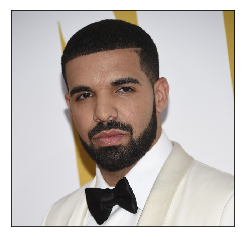

In [2]:
im = Image.open('./images/Drake-1510152261-640x619.jpg')
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(im)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax
plt.show()

  * lambda functions
  * bounding box coordinates
  * custom head; bounding box regression

## 00:01:43 - Prerequisites from Fast.ai Part 1

* Knowledge of how to print out inputs from DataLoader.
* How to view model outputs.

## 00:03:02 - Pascal notebook

Revisiting code from last lesson:

In [3]:
PATH = Path('./data/pascal/')

In [4]:
PATH.mkdir(exist_ok=True)

In [5]:
train_json = json.load((PATH / 'PASCAL_VOC' / 'pascal_train2007.json').open())
train_json.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [6]:
train_json['annotations'][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

In [7]:
train_json['categories'][:4]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'},
 {'id': 4, 'name': 'boat', 'supercategory': 'none'}]

In [8]:
categories = {cat['id']: cat['name'] for cat in train_json['categories']}

train_filenames = {img['id']: img['file_name'] for img in train_json['images']}
train_ids = [img['id'] for img in train_json['images']]

In [9]:
list((PATH / 'VOCdevkit' / 'VOC2007').iterdir())

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationObject'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/ImageSets'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/Annotations')]

In [10]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [11]:
IMG_PATH = PATH / JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007594.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005682.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005016.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/001930.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007666.jpg')]

Get largest bounding box for an image:

In [12]:
def get_largest(bounding_box):
    if not bounding_box:
        raise Exception()
    
    output = sorted(
        bounding_box, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return output[0]

In [51]:
def convert_to_numpy_bb(bb):
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

def convert_to_hw_bb(a):
    return np.array([a[1], a[0], a[3] - a[1] + 1, a[2] - a[0] + 1])

train_annotations = defaultdict(lambda:[])
for o in train_json['annotations']:
    if not o['ignore']:
        bb = o['bbox']
        bb = convert_to_numpy_bb(bb)
        train_annotations[o['image_id']].append((bb, o['category_id']))
        
len(train_annotations)

2501

In [14]:
train_largest_annotations = {
    a: get_largest(b) for a, b in train_annotations.items()}

In [15]:
(PATH / 'tmp').mkdir(exist_ok=True)
BB_CSV = PATH / 'tmp' / 'bb.csv'

In [36]:
bb = np.array([train_largest_annotations[o][0] for o in train_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [train_filenames[o] for o in train_ids], 'bbox': bbs}, columns=['fn', 'bbox'])
df.to_csv(BB_CSV, index=False)

In [37]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n']

In [43]:
augs = [
    RandomFlip(),
    RandomRotate(30),
    RandomLighting(0.1, 0.1)
]

In [39]:
f_model = resnet34
sz=224
bs=64

Note that `ImageClassifierData` accepts `continuous=True`, to basically turn it into a data loader for a regression problem (doesn't one-hot encode the labels). This is expected to be fixed in future versions of Fast.ai.

In [41]:
tfms = tfms_from_model(
    f_model, sz, aug_tfms=transforms_side_on)
model_data = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=bs)

## 00:04:46 - Data augmentations and bounding boxes

* Data augmentations in Fast.ai are usually passed to ``tfms_from_model`` as a ``transforms_side_on``. Can also pass the augmentations manually, as above.
* If you apply augmentations on images, without applying to bounding boxes, the bounding boxes are going to be in the wrong place:

In [129]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
    
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

[ 115.   63.  241.  312.]
[ 115.   63.  241.  312.]
[ 115.   63.  241.  312.]
[ 115.   63.  241.  312.]
[ 115.   63.  241.  312.]
[ 115.   63.  241.  312.]
[ 115.   63.  241.  312.]
[ 115.   63.  241.  312.]
[ 115.   63.  241.  312.]


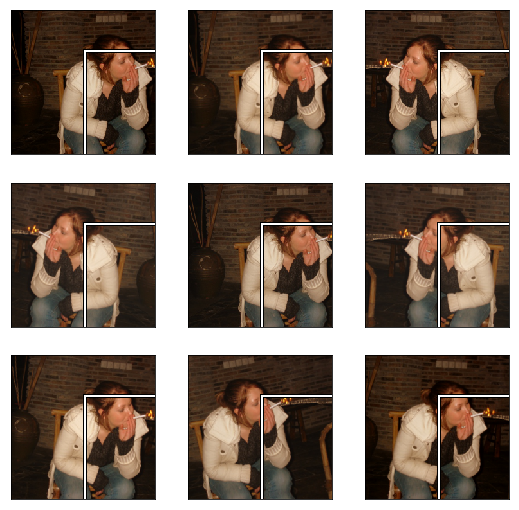

In [60]:
idx=3
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for i, ax in enumerate(axes.flat):
    x, y = next(iter(model_data.aug_dl))
    ima = model_data.val_ds.denorm(to_np(x))[idx]
    b = convert_to_hw_bb(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.show()

* Need to ensure bounding boxes (dependant variable) has same transformation as independant.
  * Can add `tfm_y` argument to do that.
    * Takes a `TfmType` enum.
    * `COORD` = y is coordinates.

In [63]:
augs = [
    RandomFlip(tfm_y=TfmType.COORD),
    RandomRotate(30, tfm_y=TfmType.COORD),
    RandomLighting(0.1, 0.1, tfm_y=TfmType.COORD)
]

* Need to add the same thing to `tfms_from_model` since it does cropping, zooming, resizing etc.

In [64]:
tfms = tfms_from_model(
    f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
model_data = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=bs)

* The bounding boxes are now in the right place:

[  61.   34.  113.  189.]
[  66.   38.  105.  183.]
[  43.   29.  128.  194.]
[  38.   23.  143.  200.]
[  24.   11.  152.  212.]
[  52.   20.  139.  203.]
[  34.   20.  154.  203.]
[  48.   34.  113.  189.]
[  58.   27.  125.  196.]


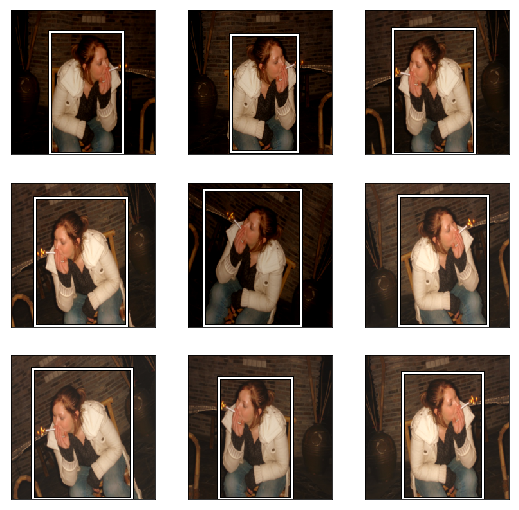

In [65]:
idx=3
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for i, ax in enumerate(axes.flat):
    x, y = next(iter(model_data.aug_dl))
    ima = model_data.val_ds.denorm(to_np(x))[idx]
    b = convert_to_hw_bb(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.show()

### 00:08:18 - Why do the bounding boxes look strange when rotated?

* The bounding boxes don't tell you where the woman's head is, so it does a best effort to generate new information based on what it knows: use rotations sparingly.
  * To avoid the problem, do a maximum of 3º rotation and only rotate half the time:

In [69]:
augs = [
    RandomFlip(tfm_y=TfmType.COORD),
    RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
    RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD)
]

tfms = tfms_from_model(
    f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
model_data = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=bs)

## 00:09:38 - Custom head revisited

* Can add a "custom head" to add your own module on a conv net, instead of adative pooling and a fully connected network.
  * We don't want to do any pooling because you want to know the activations of each grid cell.
* At the end of the Convolution section, before we hit flatten, you can see we have an input shape of 512 * 7 * 7, which is equal to `25088`, hence that being the input size of the linear layer.

```
('BasicBlock-122',
  OrderedDict([('input_shape', [-1, 512, 7, 7]),
               ('output_shape', [-1, 512, 7, 7]),
               ('nb_params', 0)])),
```

In [70]:
512 * 7 * 7

25088

In [82]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088, 4))
learn = ConvLearner.pretrained(f_model, model_data, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [83]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

In [86]:
learn.lr_find(1e-5, 100)

A Jupyter Widget

 78%|███████▊  | 25/32 [00:13<00:03,  1.90it/s, loss=354] 

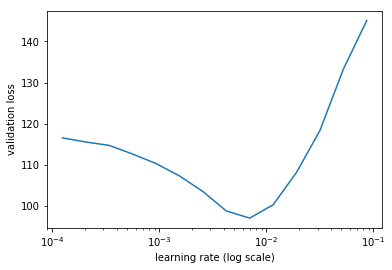

In [89]:
learn.sched.plot(5)

In [90]:
lr = 2e-3

In [92]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      27.714345  27.407628 
    1      26.421044  26.089985                           
    2      24.793674  25.781205                           



[array([ 25.7812])]

In [93]:
lrs = np.array([lr / 100, lr / 10, lr])

In [94]:
learn.freeze_to(-2)

In [95]:
lrf = learn.lr_find(lrs / 1000)

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      67.29691   2.23702145657e+16



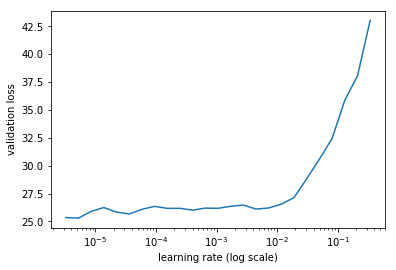

In [96]:
learn.sched.plot(1)

In [97]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      25.743794  24.21646  
    1      22.83712   21.485585                           
    2      19.489103  20.284183                           



[array([ 20.28418])]

In [98]:
learn.freeze_to(-3)

In [99]:
learn.fit(lrs, 1, cycle_len=2)

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      18.560688  23.096925 
    1      16.710485  19.988344                           



[array([ 19.98834])]

In [100]:
learn.save('reg4')

In [101]:
learn.load('reg4')

In [103]:
x, y = next(iter(model_data.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

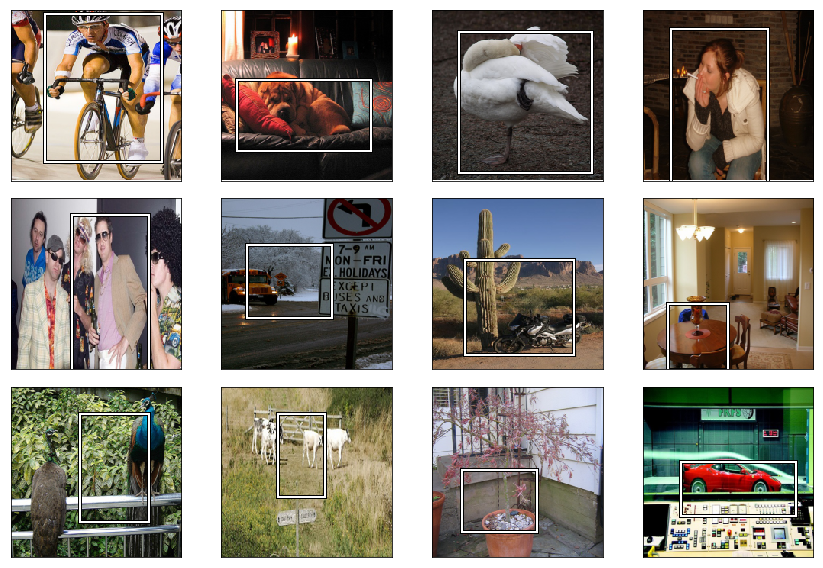

In [105]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ima = model_data.val_ds.denorm(to_np(x))[i]
    b = convert_to_hw_bb(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

## 00:10:35 - Bounding boxes and classification

* 3 things you need to do to train a neural network:
  1. Provide data.
  2. Pick architecture.
  3. Loss function.
* Need to figure out those things for this problem.

In [106]:
f_model = resnet34
sz = 224
bs = 64

In [109]:
val_idxs = get_cv_idxs(len(train_filenames))

* Want a ModelData object that has the images as independant and the dependance should a tuple with the first element the bounding box coords and the second the class.
  * One way to do it, is to create 2 model data objects and merge them together in a new dataset class.

In [110]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)

In [111]:
model_data = ImageClassifierData.from_csv(
    PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, val_idxs=val_idxs)

I'll create the image CSV from the image filenames and class:

In [114]:
CSV = PATH / 'tmp/train_labels.csv'
df = pd.DataFrame(
    {'fn': [train_filenames[o] for o in train_ids],
    'cat': [categories[train_largest_annotations[o][1]] for o in train_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

In [115]:
model_data2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

In [121]:
class ConcatLabelDataset(Dataset):
    """Takes a dataset and the y value from a second dataset and concat them together."""
    def __init__(self, dataset, y2):
        self.ds, self.y2 = dataset, y2

    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, i):
        x, y = self.ds[i]
        return (x, (y, self.y2[i]))

In [122]:
train_ds2 = ConcatLabelDataset(model_data.trn_ds, model_data2.trn_y)
val_ds2 = ConcatLabelDataset(model_data.val_ds, model_data2.val_y)

In [124]:
print('Bounding box and class label:', val_ds2[0][1])

Bounding box and class label: (array([   0.,   49.,  205.,  180.], dtype=float32), 14)


Then you can replace the dataloader's dataset with the new ones:

In [125]:
model_data.trn_dl.dataset = train_ds2
model_data.val_dl.dataset = val_ds2

Then test it by grabbing a batch of data and taking a look:

In [126]:
x, y = next(iter(model_data.val_dl))
idx = 3
ima = model_data.val_ds.ds.denorm(to_np(x))[idx]

In [127]:
b = convert_to_hw_bb(to_np(y[0][idx])); b

array([  52.,   38.,  107.,  185.])

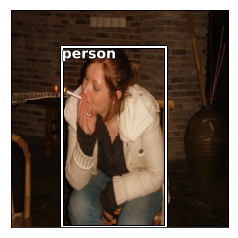

In [130]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], model_data2.classes[y[1][idx]])

### 00:13:59 - Model Architecture

* Ensure last layer outputs bounding boxes, as well as an activation per class:

In [143]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 4 + len(categories)))



models = ConvnetBuilder(f_model, c=0, is_multi=False, is_reg=False, custom_head=head_reg4)

learn = ConvLearner(model_data, models)
learn.opt_fn = optim.Adam

* No batch norm after flatten because Resnet already has one.

### 00:15:57 - Loss function

* Needs to look at 4 + c activations and decide if it's good: does it represent the bounding boxes + class of the image.

In [161]:
def detn_loss(inp, target):
    bounding_box_target, category_target = target
    bounding_box_input, category_input = inp[:, :4], inp[:, 4:]
    bounding_box_input = F.sigmoid(bounding_box_input) * 224
    
    # Adds 20 as a multiplier to make the values around equal.
    return (
        F.l1_loss(bounding_box_input, bounding_box_target) +
        F.cross_entropy(category_input, category_target) * 20
    )

def detn_l1(inp, target):
    bounding_box_target, _ = target
    bounding_box_input = inp[:, :4]
    bounding_box_input = F.sigmoid(bounding_box_input) * 224
    return F.l1_loss(V(bounding_box_input), V(bounding_box_target)).data

def detn_acc(inp, target):
    _, category_target = target
    category_input = inp[:, 4:]
    import ipdb; ipdb.set_trace()
    return accuracy_np(category_input, category_target)

In [155]:
learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

In [146]:
learn.lr_find()

A Jupyter Widget

 22%|██▏       | 7/32 [00:05<00:19,  1.26it/s, loss=131]

Exception in thread Thread-24:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 97%|█████████▋| 31/32 [00:14<00:00,  2.08it/s, loss=372]


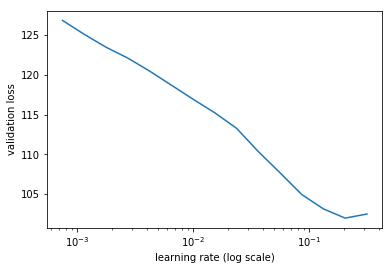

In [147]:
learn.sched.plot()

In [148]:
lr = 1e-2

In [162]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32, 5))

A Jupyter Widget

AxisError: axis 1 is out of bounds for array of dimension 1